### Import Libraries

In [1]:
# Load, explore, process and plot data
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk

# Train Test Split
from sklearn.model_selection import train_test_split,cross_val_score

#Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Machine Larning Modeling
import sklearn
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV


# Deep Learning Modeling
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Embedding,SpatialDropout1D, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences



# Performance metrices
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.utils.np_utils import to_categorical


#Logging
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

## Load Datasets

In [2]:
data_frame_train = pd.read_csv('dataset/BBC News Train.csv')
data_frame_test = pd.read_csv('dataset/BBC News Test.csv')
print(data_frame_train.shape)
print(data_frame_test.shape)

(1490, 3)
(735, 2)


In [4]:
data_frame_train

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [3]:
data_frame_test

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
...,...,...
730,1923,eu to probe alitalia state aid the european ...
731,373,u2 to play at grammy awards show irish rock ba...
732,1704,sport betting rules in spotlight a group of mp...
733,206,alfa romeos to get gm engines fiat is to sto...


In [4]:
data_frame_train.Category.unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

In [5]:
data_frame_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [6]:
data_frame_train['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [7]:
data_frame_train.isnull().any()

ArticleId    False
Text         False
Category     False
dtype: bool

In [8]:
category_count = data_frame_train['Category'].value_counts()
categories = category_count.index
categories

Index(['sport', 'business', 'politics', 'entertainment', 'tech'], dtype='object')

## Exploratory Data Analysis

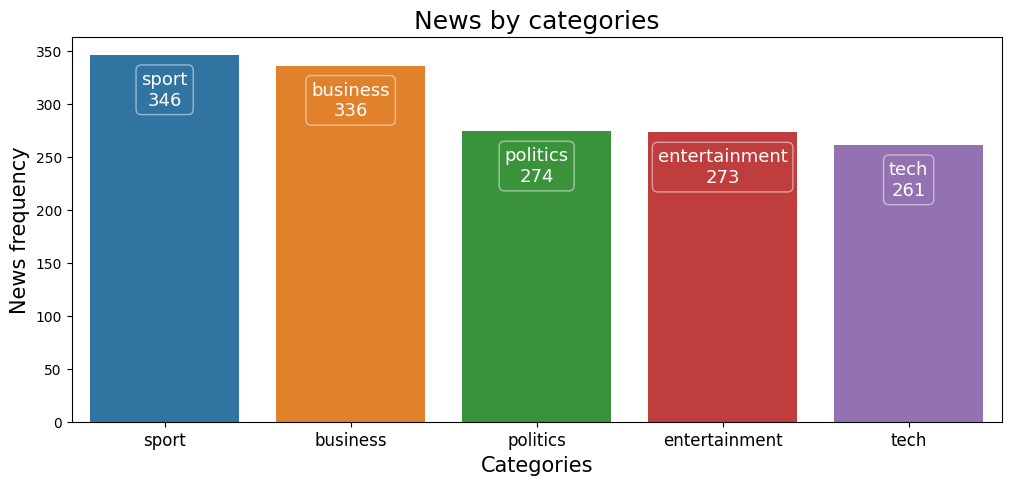

In [9]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
    
plt.xlabel('Categories', size = 15)

plt.ylabel('News frequency', size= 15)

plt.xticks(size = 12)

plt.title("News by categories" , size = 18)

plt.show()

## Text Preprocessing

In [10]:
def preprocessing(sentence):
  sentence = re.sub(r"n\'t", " not", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"\'s", " is", sentence)
  sentence = re.sub(r"\'d", " would", sentence)
  sentence = re.sub(r"\'ll", " will", sentence)
  sentence = re.sub(r"\'t", " not", sentence)
  sentence = re.sub(r"\'ve", " have", sentence)
  sentence = re.sub(r"\'m", " am", sentence)
  sentence = re.sub(r"wont", "will not", sentence)
  sentence = re.sub(r"wouldnt", "would not", sentence)
  sentence = re.sub(r"shouldnt", "should not", sentence)
  sentence = re.sub(r"couldnt", "could not", sentence)
  sentence = re.sub(r"cudnt", "could not", sentence)
  sentence = re.sub(r"cant", "can not", sentence)
  sentence = re.sub(r"dont", "do not", sentence)
  sentence = re.sub(r"doesnt", "does not", sentence)
  sentence = re.sub(r"didnt", "did not", sentence)
  sentence = re.sub(r"wasnt", "was not", sentence)
  sentence = re.sub(r"werent", "were not", sentence)
  sentence = re.sub(r"havent", "have not", sentence)
  sentence = re.sub(r"hadnt", "had not", sentence)
  sentence = re.sub(r"ain't", "am not",sentence)
  sentence = re.sub(r"aren't", "are not",sentence)
  sentence = re.sub(r"can't", "cannot",sentence)
  sentence = re.sub(r"can't've", "cannot have",sentence)
  sentence = re.sub(r"'cause", "because",sentence)
  sentence = re.sub(r"could've", "could have",sentence)
  sentence = re.sub(r"couldn't", "could not",sentence)
  sentence = re.sub(r"couldn't've", "could not have",sentence)
  sentence = re.sub(r"didn't", "did not",sentence)
  sentence = re.sub(r"doesn't", "does not",sentence)
  sentence = re.sub(r"don't", "do not",sentence)
  sentence = re.sub(r"hadn't", "had not",sentence)
  sentence = re.sub(r"hadn't've", "had not have",sentence)
  sentence = re.sub(r"hasn't", "has not",sentence)
  sentence = re.sub(r"haven't", "have not",sentence)
  sentence = re.sub(r"he'd", "he would",sentence)
  sentence = re.sub(r"he'd've", "he would have",sentence)
  sentence = re.sub(r"he'll", "he will",sentence)
  sentence = re.sub(r"he'll've", "he will have",sentence)
  sentence = re.sub(r"he's", "he is",sentence)
  sentence = re.sub(r"how'd", "how did",sentence)
  sentence = re.sub(r"how'd'y", "how do you",sentence)
  sentence = re.sub(r"how'll", "how will",sentence)
  sentence = re.sub(r"how's", "how is",sentence)
  sentence = re.sub(r"i'd", "I would",sentence)
  sentence = re.sub(r"i'd've", "I would have",sentence)
  sentence = re.sub(r"i'll", "I will",sentence)
  sentence = re.sub(r"i'll've", "I will have",sentence)
  sentence = re.sub(r"i'm", "I am",sentence)
  sentence = re.sub(r"i've", "I have",sentence)
  sentence = re.sub(r"isn't", "is not",sentence)
  sentence = re.sub(r"it'd", "it had",sentence)
  sentence = re.sub(r"it'd've", "it would have",sentence)
  sentence = re.sub(r"it'll", "it will",sentence)
  sentence = re.sub(r"it'll've", "it will have",sentence)
  sentence = re.sub(r"it's", "it is",sentence)
  sentence = re.sub(r"let's", "let us",sentence)
  sentence = re.sub(r"ma'am", "madam",sentence)
  sentence = re.sub(r"mayn't", "may not",sentence)
  sentence = re.sub(r"might've", "might have",sentence)
  sentence = re.sub(r"mightn't", "might not",sentence)
  sentence = re.sub(r"mightn't've", "might not have",sentence)
  sentence = re.sub(r"must've", "must have",sentence)
  sentence = re.sub(r"mustn't", "must not",sentence)
  sentence = re.sub(r"mustn't've", "must not have",sentence)
  sentence = re.sub(r"needn't", "need not",sentence)
  sentence = re.sub(r"needn't've", "need not have",sentence)
  sentence = re.sub(r"o'clock", "of the clock",sentence)
  sentence = re.sub(r"oughtn't", "ought not",sentence)
  sentence = re.sub(r"oughtn't've", "ought not have",sentence)
  sentence = re.sub(r"shan't", "shall not",sentence)
  sentence = re.sub(r"sha'n't", "shall not",sentence)
  sentence = re.sub(r"shan't've", "shall not have",sentence)
  sentence = re.sub(r"she'd", "she would",sentence)
  sentence = re.sub(r"she'd've", "she would have",sentence)
  sentence = re.sub(r"she'll", "she will",sentence)
  sentence = re.sub(r"she'll've", "she will have",sentence)
  sentence = re.sub(r"she's", "she is",sentence)
  sentence = re.sub(r"should've", "should have",sentence)
  sentence = re.sub(r"shouldn't", "should not",sentence)
  sentence = re.sub(r"shouldn't've", "should not have",sentence)
  sentence = re.sub(r"so've", "so have",sentence)
  sentence = re.sub(r"so's", "so is",sentence)
  sentence = re.sub(r"that'd", "that would",sentence)
  sentence = re.sub(r"that'd've", "that would have",sentence)
  sentence = re.sub(r"that's", "that is",sentence)
  sentence = re.sub(r"there'd", "there had",sentence)
  sentence = re.sub(r"there'd've", "there would have",sentence)
  sentence = re.sub(r"there's", "there is",sentence)
  sentence = re.sub(r"they'd", "they would",sentence)
  sentence = re.sub(r"they'd've", "they would have",sentence)
  sentence = re.sub(r"they'll", "they will",sentence)
  sentence = re.sub(r"they'll've", "they will have",sentence)
  sentence = re.sub(r"they're", "they are",sentence)
  sentence = re.sub(r"they've", "they have",sentence)
  sentence = re.sub(r"to've", "to have",sentence)
  sentence = re.sub(r"wasn't", "was not",sentence)
  sentence = re.sub(r"we'd", "we had",sentence)
  sentence = re.sub(r"we'd've", "we would have",sentence)
  sentence = re.sub(r"we'll", "we will",sentence)
  sentence = re.sub(r"we'll've", "we will have",sentence)
  sentence = re.sub(r"we're", "we are",sentence)
  sentence = re.sub(r"we've", "we have",sentence)
  sentence = re.sub(r"weren't", "were not",sentence)
  sentence = re.sub(r"what'll", "what will",sentence)
  sentence = re.sub(r"what'll've", "what will have",sentence)
  sentence = re.sub(r"what're", "what are",sentence)
  sentence = re.sub(r"what's", "what is",sentence)
  sentence = re.sub(r"what've", "what have",sentence)
  sentence = re.sub(r"when's", "when is",sentence)
  sentence = re.sub(r"when've", "when have",sentence)
  sentence = re.sub(r"where'd", "where did",sentence)
  sentence = re.sub(r"where's", "where is",sentence)
  sentence = re.sub(r"where've", "where have",sentence)
  sentence = re.sub(r"who'll", "who will",sentence)
  sentence = re.sub(r"who'll've", "who will have",sentence)
  sentence = re.sub(r"who's", "who is",sentence)
  sentence = re.sub(r"who've", "who have",sentence)
  sentence = re.sub(r"why's", "why is",sentence)
  sentence = re.sub(r"why've", "why have",sentence)
  sentence = re.sub(r"will've", "will have",sentence)
  sentence = re.sub(r"won't", "will not",sentence)
  sentence = re.sub(r"won't've", "will not have",sentence)
  sentence = re.sub(r"would've", "would have",sentence)
  sentence = re.sub(r"wouldn't", "would not",sentence)
  sentence = re.sub(r"wouldn't've", "would not have",sentence)
  sentence = re.sub(r"y'all", "you all",sentence)
  sentence = re.sub(r"y'alls", "you alls",sentence)
  sentence = re.sub(r"y'all'd", "you all would",sentence)
  sentence = re.sub(r"y'all'd've", "you all would have",sentence)
  sentence = re.sub(r"y'all're", "you all are",sentence)
  sentence = re.sub(r"y'all've", "you all have",sentence)
  sentence = re.sub(r"you'd", "you had",sentence)
  sentence = re.sub(r"you'd've", "you would have",sentence)
  sentence = re.sub(r"you'll", "you you will",sentence)
  sentence = re.sub(r"you'll've", "you you will have",sentence)
  sentence = re.sub(r"you're", "you are",sentence)
  sentence = re.sub(r"you've", "you have",sentence)

  
  sentence = re.sub(r'[^\w\s]','',sentence) # Remove Punctutation
  
  sentence = sentence.lower() # Lower case
  
  CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  sentence = re.sub(CLEANR, '', sentence)# Remove HTML
  
  sentence = re.sub('[^A-Za-z]',' ',sentence)# Remove Digits
 
  sentence = re.sub(r'[\w._%+-]{1,20}@[\w.-]{1,20}.[A-Za-z]{2,3}','', sentence)# Remove Email
  
  sentence = re.sub(r'^http?s:\/\/.*[\r\n]*','', sentence)# Remove URLs
  
  sentence = re.sub(r'@[A-Za-z0-9]+','',sentence) #Remove Mentions  

  sentence = " ".join(item for item in sentence.split() if item not in stopwords.words('english') )
  
  sentence = ' '.join([PorterStemmer().stem(word)for word in sentence.split()])

  sentence = ' '.join([WordNetLemmatizer().lemmatize(word) for word in sentence.split()])
  return sentence


In [11]:
data_frame_train['Token'] = data_frame_train.Text.apply(lambda sentence : preprocessing(sentence))

In [12]:
data_frame_train.head()

,ArticleId,Text,Category,Token
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launch defenc lawyer defend fo...
1,154,german business confidence slides german busin...,business,german busi confid slide german busi confid fe...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indic econom gloom citizen major nati...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyl govern mobil choic faster better funk...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bos payout eighteen former enron directo...


In [13]:
X = data_frame_train.Token
Y = data_frame_train.Category
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1192,) (1192,)
(298,) (298,)


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
TfIdf_Vectorizer = TfidfVectorizer(tokenizer = token.tokenize)

X_train_transformed = TfIdf_Vectorizer.fit_transform(X_train)

#X_test_transformed = TfIdf_Vectorizer.transform(X_test)

In [15]:
with open("TF-IDF/TfIdf_Vectorizer.pk", "wb") as f:
    pk.dump(TfIdf_Vectorizer, f)

with open("TF-IDF/TfIdf_Vectorizer.pk", "rb") as f:
    vector = pk.load(f)

## Convert Categorical labels into numerics

In [16]:
label_fit = LabelEncoder()
label_fit.fit(Y)
Y_train_transformed = label_fit.transform(Y_train)
Y_test_transformed = label_fit.transform(Y_test)
print(label_fit.classes_)

['business' 'entertainment' 'politics' 'sport' 'tech']


In [17]:
class_names = label_fit.classes_
class_names

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [18]:
integer_mapping = {l: i for i, l in enumerate(label_fit.classes_)}

In [21]:
integer_mapping

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

In [19]:
with open("Labels/label_fit.pk", "wb") as f:
    pk.dump(label_fit, f)

with open("Labels/label_fit.pk", "rb") as f:
    label_fit = pk.load(f)

**Display Output in Heat Map**

In [20]:
def plot_matrix(y_test, y_pred, color="Greens"):
    labels = np.unique(y_pred)
    cm_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index=labels, columns=labels)
    sns.heatmap(cm_df, annot=True, fmt='g', cmap=color)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

## Naive Bayes

**Multinomial NB**

Average accuracy on test set=0.959731543624161
              precision    recall  f1-score   support

           0       0.99      0.95      0.97        78
           1       0.96      1.00      0.98        44
           2       0.95      0.90      0.92        59
           3       1.00      0.97      0.98        65
           4       0.90      1.00      0.95        52

    accuracy                           0.96       298
   macro avg       0.96      0.96      0.96       298
weighted avg       0.96      0.96      0.96       298



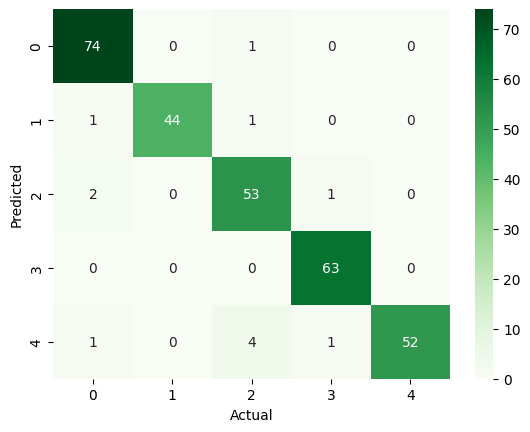

In [21]:
model_MNB = MultinomialNB()
model_MNB.fit(X_train_transformed, Y_train_transformed)
Y_predicted_MNB = model_MNB.predict(TfIdf_Vectorizer.transform(X_test))
print('Average accuracy on test set={}'.format(np.mean(Y_predicted_MNB == label_fit.transform(Y_test))))
print(classification_report(Y_predicted_MNB,Y_test_transformed))
plot_matrix(Y_test_transformed, Y_predicted_MNB)

In [22]:
with open("models/model_MNB.pk", "wb") as f:
    pk.dump(model_MNB, f)

with open("models/model_MNB.pk", "rb") as f:
    model_MNB = pk.load(f) 

In [23]:
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import wordnet
def detect_catagory(model,article):
  sentence = preprocessing(article)
  sentence = list(sentence.split(" "))
  p_tfidf = vector.transform(sentence)
  result1 = model.predict(p_tfidf)[0]
  result = label_fit.inverse_transform(model.predict(p_tfidf))[0]
  probability_score = model.predict_proba(p_tfidf)[result1]
        
  return result,probability_score

In [24]:
import random
try:
  test_sentences = data_frame_test['Text'].to_list()
  test_samples = random.sample(test_sentences, 1)
  for item in test_samples:
    message = preprocessing(str(item))
    input = [message]
    p_tfidf = vector.transform(input)
    predict_index = model_MNB.predict(p_tfidf)[0]
    predict_category = label_fit.inverse_transform(model_MNB.predict(p_tfidf))[0]
    #score = model_MNB.predict_proba(vector.transform(input))[predict_index]
    print(f"Predict Index: {predict_index}")
    #print(f"Predict Probabilities: {score}")
    print(f"Predict Category: {predict_category}")
    
    print(f"Predict Text: {item}")
       
    print("---------------------------------------------------------\n")
except Exception as e:
  print(f'Error raised!!: {e}') 

Predict Index: 2
Predict Category: politics
Predict Text: labour accused of  eu propaganda  a  taxpayer subsidised propaganda exercise  on the eu is being used to lull the british public into a false sense of security  say the tories.  shadow foreign secretary michael ancram told mps a new white paper was part of trying to soften up opinion ahead of the referendum on the eu constitution. his claims were denied by foreign secretary jack straw  who accused the tories of  running scared  of debate. eu cooperation would help get better uk immigration controls  he argued.  mr straw used thursday s commons debate to launch the new white paper on the prospects for the eu in 2005. security  stability and prosperity would be the key themes when the uk took over the chairmanship of the eu in july  said mr straw. africa and climate change would also feature highly. he said the uk was trying to ensure future eu budgets were limited to 1% of europe s economic output and were spent  where it adds mo

In [25]:
article1 = '''Google Pixel has added a new spatial audio feature with its January update for Pixel 6, 6 Pro, 7 and 7 Pro. The Verge has confirmed that a toggle for this feature has appeared in the settings menu of the Google Pixel 6 Pro. This update will roll out soon to other Pixel devices as well. The Google support page states that it will be able to support audio from apps with 5.1 surround sound.'''

In [26]:
article2 = '''Thursday reiterated its call for peace and tranquillity in border areas for the development of the relationship with China in the face of comments by the new Chinese foreign minister about both sides being willing to ease the situation in relation to the standoff on the Line of Actual Control (LAC).. '''

In [27]:
article3 = '''Apple has agreed to pay $50m (£41.6m) to settle a legal action by claimants in the US, over its MacBook keyboards.Customers in seven states claimed the technology giant had sold the "butterfly" keyboards, on MacBook, MacBook Air and MacBook Pro laptops, from 2015 to 2019, knowing they had unresponsive and sticky keys that could be damaged by dust or debris.Apple did not immediately respond to a BBC News request for comment.But the company denies any wrongdoing.The settlement could see customers receiving up to:$395, if they replaced multiple keyboards$125, if they replaced one
$50 for those who replaced key caps
The preliminary agreement is still subject to approval by a judge.On a typical keyboard, keys are attached using two pieces of plastic that cross each other and close like a pair of scissors when pressed.The butterfly-keyboard keys instead used a wing-like hinge.At the time, Apple said this mechanism was 40% thinner, so its laptops could be slimmer.'''

In [28]:
detect_catagory(model_MNB,article1)

('tech', array([0.21895973, 0.19043624, 0.18288591, 0.23741611, 0.17030201]))

In [29]:
detect_catagory(model_MNB,article2)

('business',
 array([0.30546017, 0.18293817, 0.2054661 , 0.19851348, 0.10762208]))

In [30]:
detect_catagory(model_MNB,article3)

('tech', array([0.23837287, 0.15522151, 0.27783055, 0.13781907, 0.19075601]))

**Bernoulli Naive Bayes**

Average accuracy on test set=0.9697986577181208
              precision    recall  f1-score   support

           0       1.00      0.91      0.96        82
           1       1.00      0.98      0.99        47
           2       0.95      0.98      0.96        54
           3       1.00      1.00      1.00        63
           4       0.90      1.00      0.95        52

    accuracy                           0.97       298
   macro avg       0.97      0.97      0.97       298
weighted avg       0.97      0.97      0.97       298



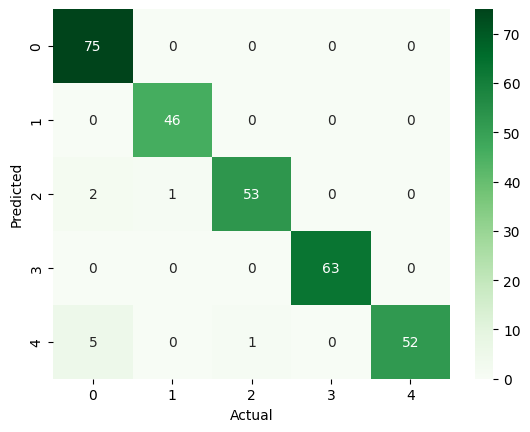

In [31]:
model_BNB = BernoulliNB()
model_BNB.fit(X_train_transformed, Y_train_transformed)
Y_predicted_BNB = model_BNB.predict(TfIdf_Vectorizer.transform(X_test))
print('Average accuracy on test set={}'.format(np.mean(Y_predicted_BNB == label_fit.transform(Y_test))))
print(classification_report(Y_predicted_BNB,Y_test_transformed))


plot_matrix(Y_test_transformed, Y_predicted_BNB)

**Complement Naive Beyes**

Average accuracy on test set=0.9765100671140939
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        75
           1       1.00      1.00      1.00        46
           2       0.95      0.96      0.95        55
           3       1.00      0.97      0.98        65
           4       0.97      0.98      0.97        57

    accuracy                           0.98       298
   macro avg       0.98      0.98      0.98       298
weighted avg       0.98      0.98      0.98       298



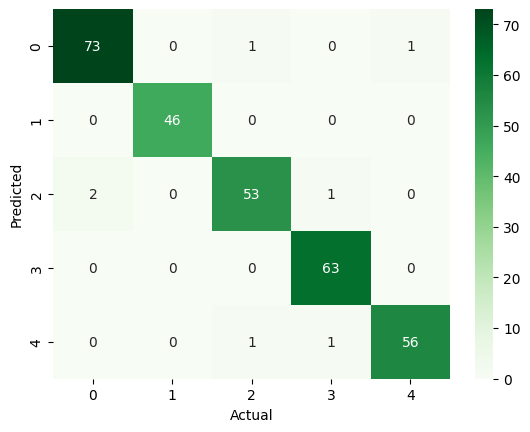

In [32]:
model_CNB = ComplementNB()
model_CNB.fit(X_train_transformed, Y_train_transformed)
Y_predicted_CNB = model_CNB.predict(TfIdf_Vectorizer.transform(X_test))
print('Average accuracy on test set={}'.format(np.mean(Y_predicted_CNB == label_fit.transform(Y_test))))
print(classification_report(Y_predicted_CNB,Y_test_transformed))


plot_matrix(Y_test_transformed, Y_predicted_CNB)

**K Nearest Neighbors**

Average accuracy on test set=0.9395973154362416
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        76
           1       0.93      0.96      0.95        45
           2       0.91      0.86      0.89        59
           3       1.00      0.98      0.99        64
           4       0.90      0.96      0.93        54

    accuracy                           0.94       298
   macro avg       0.94      0.94      0.94       298
weighted avg       0.94      0.94      0.94       298



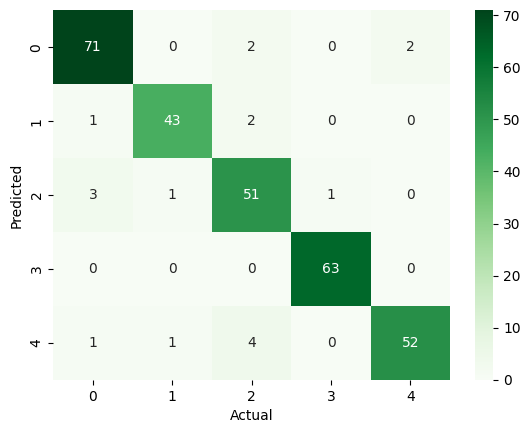

In [33]:
model_KNN = KNeighborsClassifier(n_neighbors = 5)
model_KNN.fit(X_train_transformed, Y_train_transformed)
Y_predicted_KNN = model_KNN.predict(TfIdf_Vectorizer.transform(X_test))
print('Average accuracy on test set={}'.format(np.mean(Y_predicted_KNN == label_fit.transform(Y_test))))
print(classification_report(Y_predicted_KNN,Y_test_transformed))


plot_matrix(Y_test_transformed, Y_predicted_KNN)

**Stochastic Gradient Descendent classifier**

Average accuracy on test set=0.9798657718120806
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        75
           1       0.98      0.98      0.98        46
           2       0.96      0.96      0.96        56
           3       1.00      0.97      0.98        65
           4       0.97      1.00      0.98        56

    accuracy                           0.98       298
   macro avg       0.98      0.98      0.98       298
weighted avg       0.98      0.98      0.98       298



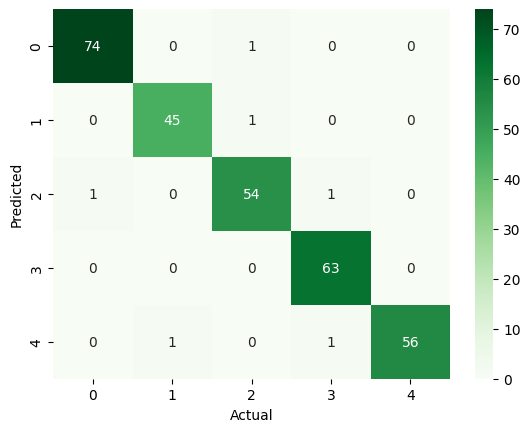

In [34]:
model_SGD = SGDClassifier(loss='hinge')
model_SGD.fit(X_train_transformed, Y_train_transformed)
Y_predicted_SGD = model_SGD.predict(TfIdf_Vectorizer.transform(X_test))
print('Average accuracy on test set={}'.format(np.mean(Y_predicted_SGD == label_fit.transform(Y_test))))
print(classification_report(Y_predicted_SGD,Y_test_transformed))


plot_matrix(Y_test_transformed, Y_predicted_SGD)

**Logistic Regression**

Average accuracy on test set=0.9664429530201343
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        77
           1       0.98      0.98      0.98        46
           2       0.95      0.95      0.95        56
           3       1.00      0.95      0.98        66
           4       0.91      1.00      0.95        53

    accuracy                           0.97       298
   macro avg       0.97      0.97      0.97       298
weighted avg       0.97      0.97      0.97       298



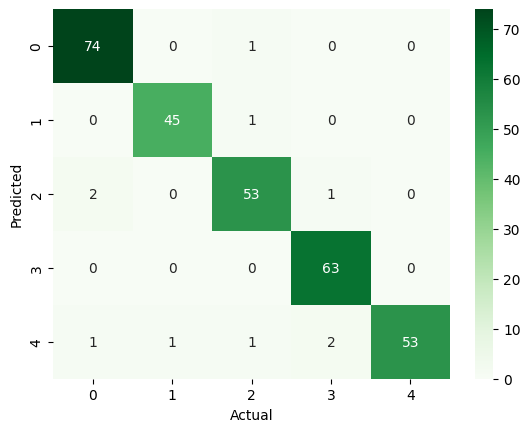

In [35]:
model_LR = LogisticRegression()
model_LR.fit(X_train_transformed, Y_train_transformed)
Y_predicted_LR = model_LR.predict(TfIdf_Vectorizer.transform(X_test))
print('Average accuracy on test set={}'.format(np.mean(Y_predicted_LR == label_fit.transform(Y_test))))
print(classification_report(Y_predicted_LR,Y_test_transformed))


plot_matrix(Y_test_transformed, Y_predicted_LR)

**Random Forest Classifier**

Average accuracy on test set=0.9496644295302014
              precision    recall  f1-score   support

           0       0.99      0.94      0.96        79
           1       0.93      0.96      0.95        45
           2       0.93      0.95      0.94        55
           3       1.00      0.93      0.96        68
           4       0.88      1.00      0.94        51

    accuracy                           0.95       298
   macro avg       0.95      0.95      0.95       298
weighted avg       0.95      0.95      0.95       298



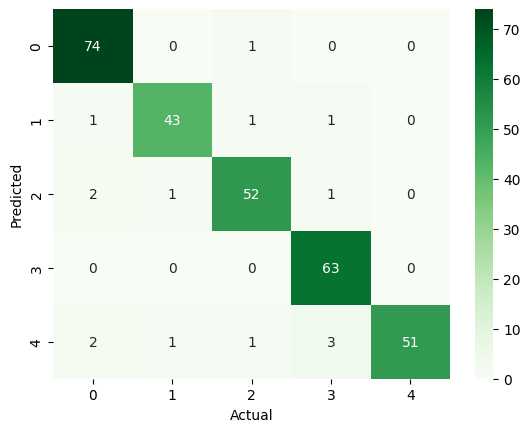

In [36]:
model_RFC = RandomForestClassifier(max_depth=10, random_state=18)
model_RFC.fit(X_train_transformed, Y_train_transformed)
Y_predicted_RFC = model_RFC.predict(TfIdf_Vectorizer.transform(X_test))
print('Average accuracy on test set={}'.format(np.mean(Y_predicted_RFC == label_fit.transform(Y_test))))
print(classification_report(Y_predicted_RFC,Y_test_transformed))


plot_matrix(Y_test_transformed, Y_predicted_RFC)

## ML Models pickel files

In [37]:

with open("models/model_BNB.pk", "wb") as f:
    pk.dump(model_BNB, f)

with open("models/model_CNB.pk", "wb") as f:
    pk.dump(model_CNB, f)

with open("models/model_MNB.pk", "wb") as f:
    pk.dump(model_MNB, f)

with open("models/model_RFC.pk", "wb") as f:
    pk.dump(model_RFC, f)

with open("models/model_SGD.pk", "wb") as f:
    pk.dump(model_SGD, f)

with open("models/model_Lreg.pk", "wb") as f:
    pk.dump(model_SGD, f)

with open("models/model_MNB.pk", "rb") as f:
    model_MNB = pk.load(f)   

with open("models/model_BNB.pk", "rb") as f:
    model_BNB = pk.load(f)   

with open("models/model_CNB.pk", "rb") as f:
    model_CNB = pk.load(f)   

with open("models/model_SGD.pk", "rb") as f:
    model_SGD = pk.load(f)   

with open("models/model_Lreg.pk", "rb") as f:
    model_Lreg = pk.load(f)   

with open("models/model_RFC.pk", "rb") as f:
    model_RFC = pk.load(f)   


## Deep Learning Prerequisite

**Hyperparameter Tuning**

In [79]:
EMBEDDING_DIMENSION = 128
VOCABULARY_SIZE = 10000
MAX_LENGTH = 500
OOV_TOK = '<OOV>'
TRUNCATE_TYPE = 'pre'
PADDING_TYPE = 'pre'


In [80]:
X = data_frame_train['Token'].values
Y = data_frame_train['Category'].values

In [81]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [82]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(X_test.shape)

(1192,)
(298,)
(1192,)
(298,)


In [83]:

tokenizer = Tokenizer(num_words=VOCABULARY_SIZE, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True,oov_token=OOV_TOK)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 16149 unique tokens.


**Pad Sequence**

In [84]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(X_train, maxlen=MAX_LENGTH,padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)
X_test = pad_sequences(X_test, maxlen=MAX_LENGTH,padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)

In [85]:
X_train[:10], X_test[:10]

(array([[   0,    0,    0, ..., 1656, 1795,  713],
        [   0,    0,    0, ..., 4033,    1,    1],
        [   0,    0,    0, ...,   88,  675,   88],
        ...,
        [   0,    0,    0, ...,   25,  112,  264],
        [   0,    0,    0, ..., 2338,  102,  640],
        [   0,    0,    0, ..., 6395,   22,  540]]),
 array([[   0,    0,    0, ...,   44,    1,    1],
        [   0,    0,    0, ...,    3, 2813,  331],
        [   0,    0,    0, ..., 2413,  109,  707],
        ...,
        [   0,    0,    0, ...,  681, 1764,  580],
        [   0,    0,    0, ...,  437,  554,    2],
        [   0,    0,    0, ...,  277,  852,  591]]))

In [86]:
# Shape of X_train and X_test
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)
     

x_train shape: (1192, 500)
x_test shape: (298, 500)


**Tokenization pickle file**

In [87]:
with open("Tokenizer/tokenizer.pk", "wb") as f:
    pk.dump(tokenizer, f)


with open("Tokenizer/tokenizer.pk", "rb") as f:
    tokenizer_pk = pk.load(f)

In [88]:
import json
# Save our tokenizer layer which is used in prediction
try:
  tokenizer_json = tokenizer.to_json()
  with open('Tokenizer/tokenizer.json', 'w', encoding='utf-8') as f:
      f.write(json.dumps(tokenizer_json, ensure_ascii=True))
except Exception as e:
  print(f'Error raised!!: {e}') 

In [90]:
from sklearn.preprocessing import OneHotEncoder
# One hot encoder
try:
  # Initialize oneHotEncoder to our labels
  one_hot_encoder = OneHotEncoder(sparse=False)
  # Train labels
  Y_train_one_hot =one_hot_encoder.fit_transform(Y_train.reshape(-1,1))
  # Test labels
  Y_test_one_hot = one_hot_encoder.transform(Y_test.reshape(-1,1))
except Exception as e:
  print(f'Error raised!!: {e}') 

In [91]:
with open("Labels/one_hot_encoder.pk", "wb") as f:
    pk.dump(one_hot_encoder, f)


with open("Labels/one_hot_encoder.pk", "rb") as f:
    one_hot_encoder_pk = pk.load(f)

In [92]:
Y_train_one_hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [93]:
from sklearn.preprocessing import LabelEncoder
# Label encoder
try:
  # Intialize label encoder to our labels
  label_encoder = LabelEncoder()
  # Train labels
  Y_train_labels_encoded = label_encoder.fit_transform(Y_train.reshape(-1,1))
  # Test labels
  Y_test_labels_encoded = label_encoder.transform(Y_test.reshape(-1,1))
except Exception as e:
  print(f'Error raised!!: {e}') 
     

C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [94]:
with open("Labels/label_encoder.pk", "wb") as f:
    pk.dump(label_encoder, f)


with open("Labels/label_encoder.pk", "rb") as f:
    label_encoder_pk = pk.load(f)

In [95]:
Y_train_labels_encoded

array([3, 0, 2, ..., 2, 1, 3])

In [96]:

# Class names
class_names = label_encoder.classes_
     

In [97]:

# Check first ten labelencoded train labels
Y_train_labels_encoded[:10]

array([3, 0, 2, 3, 2, 0, 0, 1, 0, 1])

## LSTM Model

In [99]:
n_lstm = 128
drop_lstm = 0.5

In [160]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(VOCABULARY_SIZE, EMBEDDING_DIMENSION, input_length=X_train.shape[1]))
model_LSTM.add(SpatialDropout1D(drop_lstm))
model_LSTM.add(LSTM(n_lstm,return_sequences=False,  dropout=0.2, recurrent_dropout=0.2))
model_LSTM.add(Dropout(drop_lstm))
model_LSTM.add(Dense(5, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode = min, patience=3, min_delta=0.0001)

2023-01-18 12:48:37,090 : WARNING : EarlyStopping mode <built-in function min> is unknown, fallback to auto mode.


In [161]:
history_LSTM = model_LSTM.fit(X_train, Y_train_one_hot,validation_data=(X_test, Y_test_one_hot),epochs=7,batch_size=64,verbose=1, callbacks=[es])

Epoch 1/7
19/19 [==============================] - 266s 13s/step - loss: 1.6034 - accuracy: 0.2659 - val_loss: 1.5867 - val_accuracy: 0.3356
Epoch 2/7
19/19 [==============================] - 161s 9s/step - loss: 1.4346 - accuracy: 0.4035 - val_loss: 1.1844 - val_accuracy: 0.4362
Epoch 3/7
19/19 [==============================] - 162s 9s/step - loss: 1.0813 - accuracy: 0.4664 - val_loss: 0.9995 - val_accuracy: 0.4866
Epoch 4/7
19/19 [==============================] - 162s 9s/step - loss: 0.8977 - accuracy: 0.5923 - val_loss: 0.9385 - val_accuracy: 0.7886
Epoch 5/7
19/19 [==============================] - 168s 9s/step - loss: 0.6448 - accuracy: 0.7861 - val_loss: 0.5477 - val_accuracy: 0.8658
Epoch 6/7
19/19 [==============================] - 168s 9s/step - loss: 0.3929 - accuracy: 0.8935 - val_loss: 0.4285 - val_accuracy: 0.8691
Epoch 7/7
19/19 [==============================] - 171s 9s/step - loss: 0.2988 - accuracy: 0.9136 - val_loss: 0.3373 - val_accuracy: 0.9195


In [162]:
score = model_LSTM.evaluate(X_test, Y_test_one_hot, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3372856378555298
Test accuracy: 0.9194630980491638


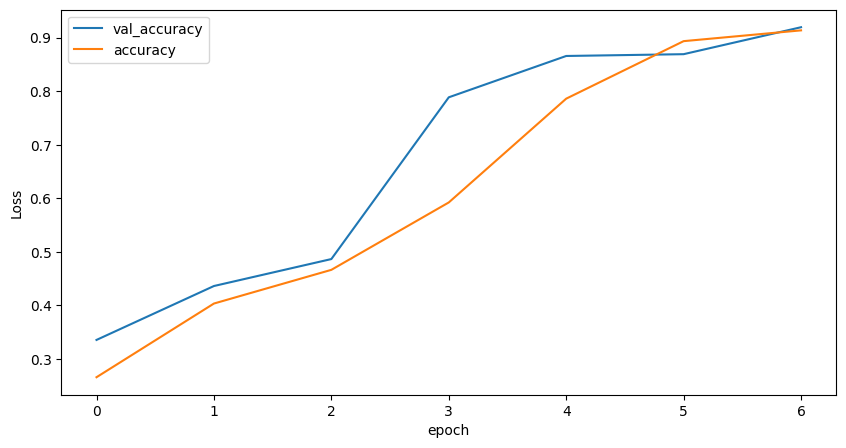

In [163]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(10,5))
plt.plot(history_LSTM.history['val_accuracy'], label='val_accuracy')
plt.plot(history_LSTM.history['accuracy'], label='accuracy')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

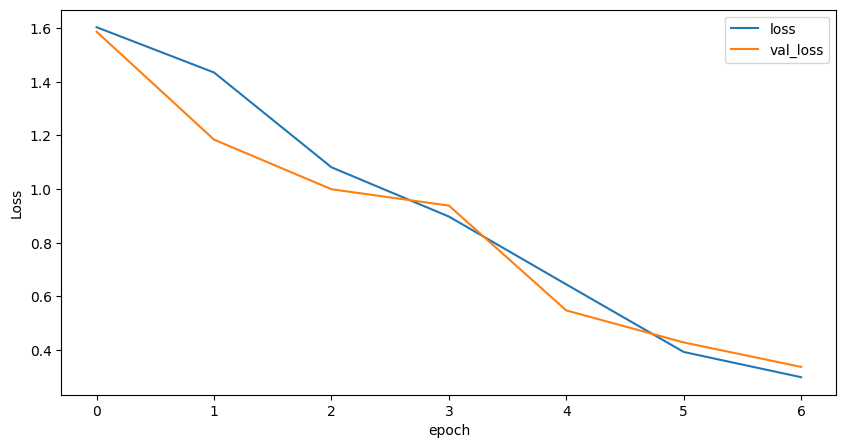

In [164]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(10,5))
plt.plot(history_LSTM.history['loss'], label='loss')
plt.plot(history_LSTM.history['val_loss'], label='val_loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [165]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def model_evaluation(Y_actual, Y_predicted):
    model_LSTM_accuracy  = accuracy_score(Y_actual, Y_predicted) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(Y_actual, Y_predicted, average="weighted")

    model_evaluation_results = {'Accuracy' : model_LSTM_accuracy,
                                'Precision' : model_LSTM_accuracy,
                                'Recall': model_recall, 
                                'F1 Score': model_f1}
    return model_evaluation_results   

In [166]:
# Evaluate on test data
model_LSTM.evaluate(X_test, Y_test_one_hot)

10/10 [==============================] - 2s 245ms/step - loss: 0.3373 - accuracy: 0.9195


[0.3372856378555298, 0.9194630980491638]

In [167]:
model_LSTM_predict_probabilities = model_LSTM.predict(X_test)

10/10 [==============================] - 3s 236ms/step


In [168]:
model_LSTM_ohe_predict_probabilities[:2]

array([[9.5427945e-02, 4.7179517e-01, 1.5294619e-01, 1.8970275e-01,
        9.0127908e-02],
       [1.3156361e-03, 2.3841009e-02, 9.6488732e-01, 7.9968735e-04,
        9.1563193e-03]], dtype=float32)

In [169]:
# Turn prediction probabilities into prediction labels
model_LSTM_predict_probabilities_labels = tensorflow.argmax(model_LSTM_predict_probabilities, axis=1)
model_LSTM_predict_probabilities_labels

<tf.Tensor: shape=(298,), dtype=int64, numpy=
array([4, 2, 2, 4, 4, 0, 4, 1, 0, 4, 2, 1, 4, 3, 4, 4, 0, 3, 2, 0, 4, 1,
       3, 0, 3, 4, 0, 3, 4, 0, 3, 0, 0, 2, 3, 4, 1, 0, 1, 2, 3, 2, 2, 0,
       3, 0, 2, 4, 2, 0, 3, 3, 0, 3, 2, 1, 1, 1, 0, 1, 4, 0, 4, 4, 4, 4,
       0, 4, 2, 2, 2, 3, 3, 3, 1, 1, 0, 2, 0, 0, 0, 3, 3, 3, 0, 1, 3, 0,
       0, 4, 1, 2, 2, 4, 0, 2, 4, 4, 1, 2, 1, 2, 1, 3, 4, 3, 2, 3, 0, 4,
       4, 0, 4, 1, 4, 2, 0, 0, 1, 0, 2, 3, 0, 2, 0, 0, 4, 4, 4, 0, 0, 3,
       1, 3, 0, 2, 2, 1, 0, 1, 0, 1, 4, 3, 1, 2, 2, 4, 2, 2, 3, 0, 4, 3,
       1, 4, 4, 3, 4, 3, 3, 2, 0, 4, 2, 2, 4, 3, 3, 4, 2, 4, 4, 1, 0, 4,
       1, 3, 0, 0, 3, 3, 4, 1, 1, 0, 4, 4, 1, 2, 3, 3, 2, 4, 3, 3, 2, 3,
       3, 0, 1, 2, 3, 1, 0, 3, 4, 4, 0, 2, 3, 2, 0, 1, 3, 2, 2, 3, 4, 2,
       3, 4, 0, 0, 1, 4, 0, 2, 2, 2, 2, 3, 3, 0, 0, 4, 0, 3, 3, 1, 2, 1,
       1, 1, 2, 0, 1, 1, 3, 4, 1, 2, 4, 3, 2, 4, 1, 3, 4, 0, 2, 2, 4, 4,
       4, 3, 3, 0, 2, 1, 3, 3, 4, 3, 3, 4, 3, 3, 2, 4, 1, 0, 0, 2, 0, 0,
     

In [170]:
model_LSTM_results = model_evaluation(Y_test_labels_encoded,model_LSTM_predict_probabilities_labels)
model_LSTM_results

{'Accuracy': 91.94630872483222,
 'Precision': 91.94630872483222,
 'Recall': 0.9194630872483222,
 'F1 Score': 0.9192852787880083}

Text(95.72222222222221, 0.5, 'Actual')

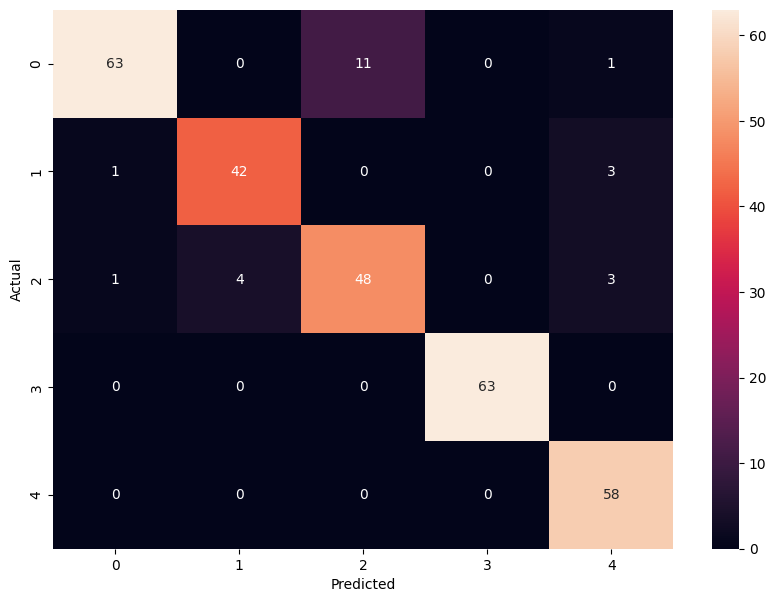

In [199]:
cm_Bi_LSTM = confusion_matrix(Y_test_labels_encoded, model_LSTM_predict_probabilities.argmax(axis=1))
plt.figure(figsize=(10,7))
sns.heatmap(cm_Bi_LSTM, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [171]:
new_complaint = ['Cricket Australia is set to begin the team’s pre-season later this month under a set of new training protocols devised for the safety of players amid the COVID-19 pandemic.']

In [175]:

seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=1000)
pred = model_LSTM.predict(padded)
preds = tensorflow.argmax(pred, axis=1)
print(pred)
print(label_encoder_pk.inverse_transform(preds))

1/1 [==============================] - 0s 486ms/step
[[0.01731935 0.9393902  0.00351021 0.0332973  0.00648284]]
['entertainment']


In [242]:

def detect_catagory_dl(model,sentence):
    message = preprocessing(sentence)
    sentence = [message]
    input_sequences = tokenizer.texts_to_sequences(sentence)
    input_pad = pad_sequences(input_sequences,maxlen=MAX_LENGTH)
    pred = model.predict(input_pad)
    preds = tensorflow.argmax(pred, axis=1)

    return pred,label_encoder_pk.inverse_transform(preds)[0]

In [243]:
detect_catagory_dl(model_LSTM,article3)

1/1 [==============================] - 0s 234ms/step


(array([[0.06815598, 0.2989159 , 0.08044846, 0.12254515, 0.42993456]],
       dtype=float32),
 'tech')

# Bi-Directional LSTM

In [180]:
model_Bi_LSTM = Sequential()
model_Bi_LSTM.add(Embedding(VOCABULARY_SIZE, EMBEDDING_DIMENSION, input_length=X_train.shape[1]))
model_Bi_LSTM.add(SpatialDropout1D(0.3))
model_Bi_LSTM.add(Bidirectional(LSTM(EMBEDDING_DIMENSION, dropout=drop_lstm)))
model_Bi_LSTM.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
model_Bi_LSTM.add(Dropout(drop_lstm))
model_Bi_LSTM.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
model_Bi_LSTM.add(Dropout(drop_lstm))
model_Bi_LSTM.add(Dense(5, activation='softmax'))
model_Bi_LSTM.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode = min, patience=3, min_delta=0.0001)

2023-01-18 14:25:43,410 : WARNING : EarlyStopping mode <built-in function min> is unknown, fallback to auto mode.


In [181]:
from tensorflow.keras.utils import plot_model
print(model_Bi_LSTM.summary())
plot_model(model_Bi_LSTM, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 spatial_dropout1d_9 (Spatia  (None, 500, 128)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)             

In [182]:
history_Bi_LSTM = model_Bi_LSTM.fit(X_train, Y_train_one_hot, validation_data=(X_test, Y_test_one_hot),epochs=7, batch_size=64,validation_split=0.1,callbacks=[es])

Epoch 1/7
19/19 [==============================] - 746s 39s/step - loss: 1.6076 - accuracy: 0.2047 - val_loss: 1.6039 - val_accuracy: 0.2114
Epoch 2/7
19/19 [==============================] - 592s 31s/step - loss: 1.6013 - accuracy: 0.2408 - val_loss: 1.5907 - val_accuracy: 0.2114
Epoch 3/7
19/19 [==============================] - 530s 27s/step - loss: 1.5699 - accuracy: 0.2978 - val_loss: 1.5421 - val_accuracy: 0.3389
Epoch 4/7
19/19 [==============================] - 222s 12s/step - loss: 1.3587 - accuracy: 0.4086 - val_loss: 1.1343 - val_accuracy: 0.6007
Epoch 5/7
19/19 [==============================] - 254s 13s/step - loss: 1.0335 - accuracy: 0.5243 - val_loss: 0.9407 - val_accuracy: 0.6376
Epoch 6/7
19/19 [==============================] - 424s 23s/step - loss: 0.7996 - accuracy: 0.6661 - val_loss: 0.6520 - val_accuracy: 0.7148
Epoch 7/7
19/19 [==============================] - 384s 20s/step - loss: 0.4661 - accuracy: 0.8062 - val_loss: 0.5558 - val_accuracy: 0.8221


In [183]:
score = model_Bi_LSTM.evaluate(X_test, Y_test_one_hot, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5558040738105774
Test accuracy: 0.8221476674079895


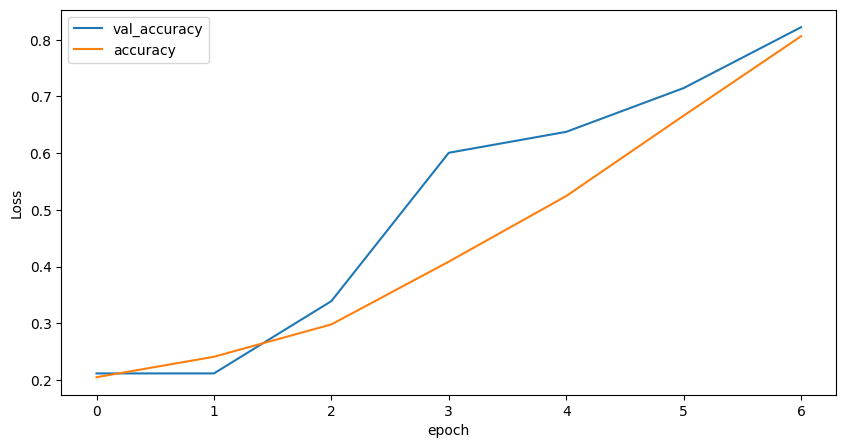

In [184]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(10,5))
plt.plot(history_Bi_LSTM.history['val_accuracy'], label='val_accuracy')
plt.plot(history_Bi_LSTM.history['accuracy'], label='accuracy')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

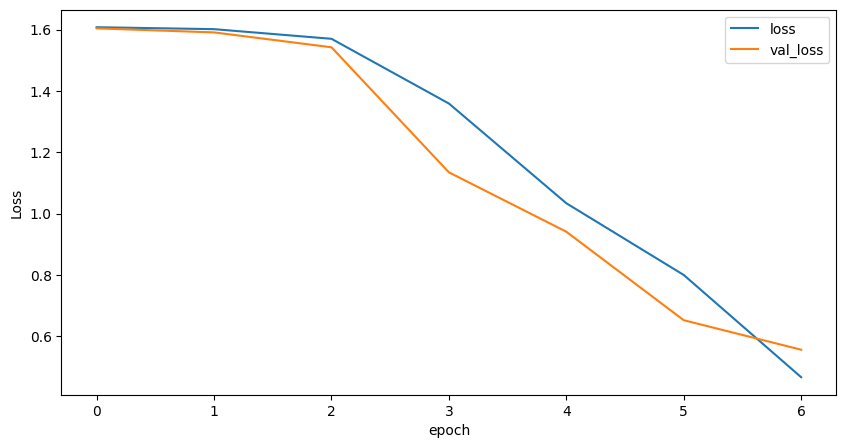

In [185]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(10,5))
plt.plot(history_Bi_LSTM.history['loss'], label='loss')
plt.plot(history_Bi_LSTM.history['val_loss'], label='val_loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [186]:
# Evaluate on test data
model_Bi_LSTM.evaluate(X_test, Y_test_one_hot)


10/10 [==============================] - 3s 261ms/step - loss: 0.5558 - accuracy: 0.8221


[0.5558040738105774, 0.8221476674079895]

In [187]:
model_Bi_LSTM_predict_probabilities = model_Bi_LSTM.predict(X_test)
model_Bi_LSTM_predict_probabilities[:2]

10/10 [==============================] - 3s 244ms/step


array([[0.32609624, 0.49925676, 0.07815088, 0.06157279, 0.0349233 ],
       [0.02626956, 0.00226213, 0.49260622, 0.00138372, 0.47747844]],
      dtype=float32)

In [190]:
# Turn prediction probabilities into prediction labels
model_Bi_LSTM_predict_probabilities_labels = tensorflow.argmax(model_Bi_LSTM_predict_probabilities, axis=1)
model_Bi_LSTM_predict_probabilities_labels


<tf.Tensor: shape=(298,), dtype=int64, numpy=
array([1, 2, 2, 4, 4, 0, 4, 1, 0, 4, 2, 1, 0, 3, 4, 2, 0, 3, 2, 0, 4, 1,
       3, 0, 3, 4, 0, 3, 4, 0, 3, 0, 0, 2, 3, 2, 0, 0, 1, 2, 3, 0, 2, 0,
       3, 0, 2, 4, 0, 0, 3, 3, 0, 3, 2, 1, 1, 1, 0, 3, 4, 0, 0, 4, 4, 4,
       0, 2, 1, 2, 2, 3, 3, 3, 1, 1, 0, 2, 0, 0, 0, 3, 3, 3, 0, 1, 3, 0,
       0, 2, 1, 0, 2, 4, 0, 0, 4, 4, 1, 2, 1, 1, 1, 3, 4, 3, 0, 3, 0, 4,
       2, 0, 2, 1, 4, 0, 0, 0, 1, 0, 1, 3, 0, 2, 0, 0, 4, 1, 0, 1, 0, 3,
       1, 3, 0, 0, 0, 1, 0, 1, 0, 1, 2, 3, 1, 2, 2, 4, 4, 2, 3, 0, 1, 3,
       1, 2, 1, 3, 4, 3, 3, 2, 0, 4, 4, 2, 4, 3, 3, 0, 2, 4, 1, 0, 0, 1,
       1, 3, 0, 0, 3, 3, 4, 1, 1, 0, 2, 2, 1, 2, 3, 3, 2, 4, 3, 3, 2, 3,
       3, 0, 1, 4, 3, 1, 0, 3, 4, 4, 0, 2, 3, 4, 0, 1, 3, 0, 2, 3, 4, 2,
       3, 1, 0, 0, 1, 1, 0, 2, 2, 2, 2, 3, 3, 0, 0, 4, 0, 3, 3, 0, 2, 1,
       1, 1, 0, 0, 1, 1, 3, 0, 1, 1, 2, 1, 0, 4, 1, 3, 2, 0, 0, 2, 1, 4,
       4, 3, 3, 0, 1, 1, 3, 3, 4, 3, 3, 1, 3, 3, 0, 2, 1, 0, 0, 2, 0, 0,
     

In [192]:
model_Bi_LSTM_results = model_evaluation(Y_test_labels_encoded,model_Bi_LSTM_predict_probabilities_labels)
model_Bi_LSTM_results


{'Accuracy': 82.21476510067114,
 'Precision': 82.21476510067114,
 'Recall': 0.8221476510067114,
 'F1 Score': 0.8163721864584761}

In [193]:
print(classification_report(Y_test_labels_encoded,model_Bi_LSTM_predict_probabilities_labels))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89        75
           1       0.71      0.91      0.80        46
           2       0.67      0.59      0.63        56
           3       0.98      0.98      0.98        63
           4       0.90      0.62      0.73        58

    accuracy                           0.82       298
   macro avg       0.82      0.81      0.81       298
weighted avg       0.83      0.82      0.82       298



Text(95.72222222222221, 0.5, 'Actual')

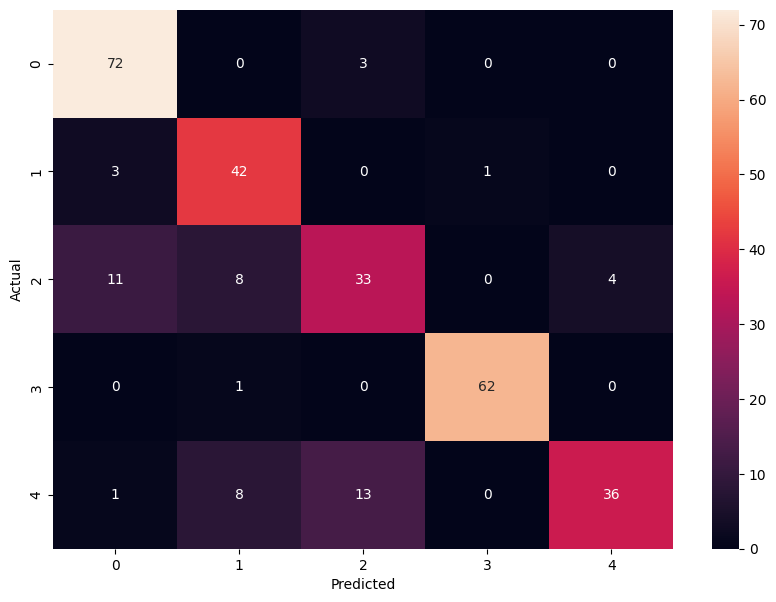

In [198]:
cm_Bi_LSTM = confusion_matrix(Y_test_labels_encoded, model_Bi_LSTM_predict_probabilities.argmax(axis=1))
plt.figure(figsize=(10,7))
sns.heatmap(cm_Bi_LSTM, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

## GRU: Gated Recurrent Unit

In [201]:
model_GRU = Sequential()
model_GRU.add(Embedding(VOCABULARY_SIZE, EMBEDDING_DIMENSION, input_length=X_train.shape[1]))
model_GRU.add(SpatialDropout1D(0.3))
model_GRU.add(GRU(EMBEDDING_DIMENSION, return_sequences = False))
model_GRU.add(Dropout(drop_lstm))
model_GRU.add(Dense(5, activation='softmax'))
model_GRU.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode = min, patience=3, min_delta=0.0001)

2023-01-18 21:41:31,360 : WARNING : EarlyStopping mode <built-in function min> is unknown, fallback to auto mode.


In [202]:
from tensorflow.keras.utils import plot_model
print(model_GRU.summary())
plot_model(model_GRU, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 500, 128)          1280000   
                                                                 
 spatial_dropout1d_10 (Spati  (None, 500, 128)         0         
 alDropout1D)                                                    
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 5)                 645       
                                                                 
Total params: 1,379,717
Trainable params: 1,379,717
Non-trainable params: 0
___________________________________________

In [203]:
history_GRU = model_GRU.fit(X_train, Y_train_one_hot, validation_data=(X_test, Y_test_one_hot),epochs=7, batch_size=64,validation_split=0.1,callbacks=[es])


Epoch 1/7
19/19 [==============================] - 70s 4s/step - loss: 1.6044 - accuracy: 0.2215 - val_loss: 1.5927 - val_accuracy: 0.2148
Epoch 2/7
19/19 [==============================] - 72s 4s/step - loss: 1.5567 - accuracy: 0.2550 - val_loss: 1.5390 - val_accuracy: 0.2483
Epoch 3/7
19/19 [==============================] - 93s 5s/step - loss: 1.3474 - accuracy: 0.6460 - val_loss: 1.3445 - val_accuracy: 0.6409
Epoch 4/7
19/19 [==============================] - 94s 5s/step - loss: 0.8751 - accuracy: 0.8230 - val_loss: 0.9582 - val_accuracy: 0.6913
Epoch 5/7
19/19 [==============================] - 97s 5s/step - loss: 0.3606 - accuracy: 0.9052 - val_loss: 0.5631 - val_accuracy: 0.7919
Epoch 6/7
19/19 [==============================] - 106s 6s/step - loss: 0.1468 - accuracy: 0.9648 - val_loss: 0.5244 - val_accuracy: 0.8322
Epoch 7/7
19/19 [==============================] - 138s 7s/step - loss: 0.0590 - accuracy: 0.9933 - val_loss: 0.4380 - val_accuracy: 0.8591


In [204]:
score = model_GRU.evaluate(X_test, Y_test_one_hot, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.43797293305397034
Test accuracy: 0.8590604066848755


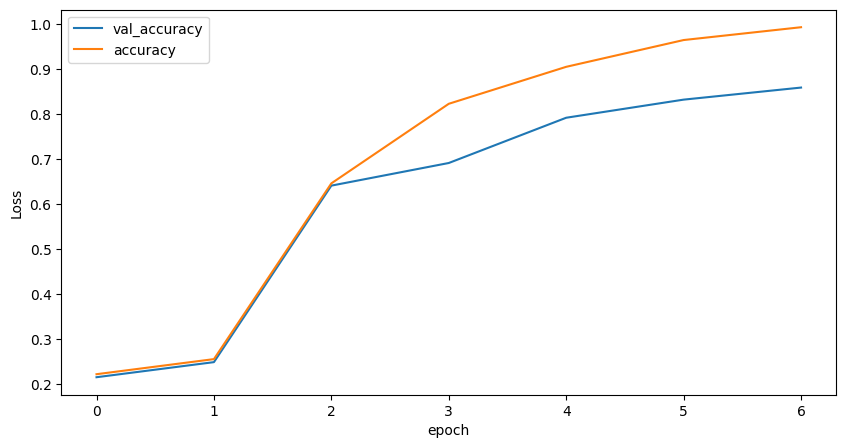

In [205]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(10,5))
plt.plot(history_GRU.history['val_accuracy'], label='val_accuracy')
plt.plot(history_GRU.history['accuracy'], label='accuracy')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

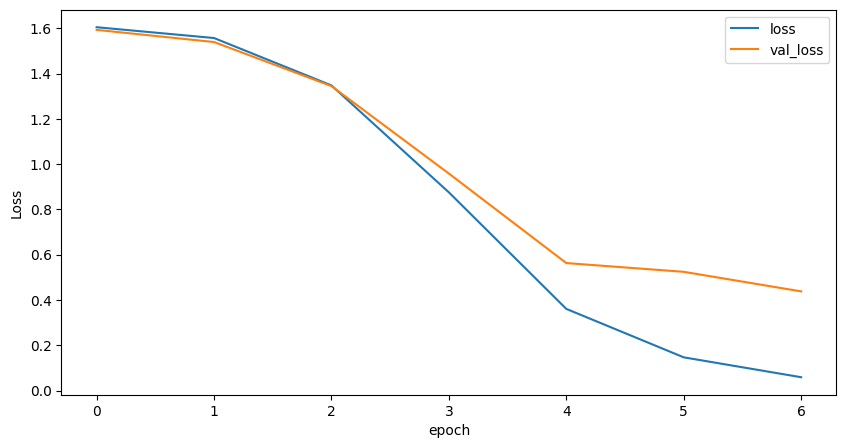

In [206]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(10,5))
plt.plot(history_GRU.history['loss'], label='loss')
plt.plot(history_GRU.history['val_loss'], label='val_loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [215]:
# Evaluate on test data
model_GRU.evaluate(X_test, Y_test_one_hot)


10/10 [==============================] - 2s 164ms/step - loss: 0.4380 - accuracy: 0.8591


[0.43797293305397034, 0.8590604066848755]

In [210]:
model_GRU_predict_probabilities = model_GRU.predict(X_test)
model_GRU_predict_probabilities[:2]

10/10 [==============================] - 2s 155ms/step


array([[5.7491573e-04, 9.7195035e-01, 3.8440901e-04, 1.2909533e-02,
        1.4180743e-02],
       [4.7114822e-03, 9.1391921e-06, 9.8822904e-01, 2.1878404e-06,
        7.0480676e-03]], dtype=float32)

In [211]:
# Turn prediction probabilities into prediction labels
model_GRU_predict_probabilities_labels = tensorflow.argmax(model_GRU_predict_probabilities, axis=1)
model_GRU_predict_probabilities_labels

<tf.Tensor: shape=(298,), dtype=int64, numpy=
array([1, 2, 2, 2, 4, 0, 4, 1, 0, 4, 2, 1, 0, 3, 4, 2, 0, 0, 2, 0, 4, 1,
       3, 0, 3, 4, 0, 3, 4, 0, 0, 0, 0, 2, 3, 2, 1, 0, 1, 2, 3, 0, 2, 0,
       3, 0, 2, 4, 2, 0, 3, 3, 0, 3, 2, 1, 1, 2, 0, 4, 4, 0, 1, 4, 4, 4,
       0, 4, 2, 2, 2, 3, 3, 3, 1, 1, 0, 2, 0, 2, 0, 3, 3, 3, 0, 1, 3, 2,
       0, 4, 1, 0, 0, 4, 0, 0, 4, 4, 1, 2, 1, 0, 1, 3, 4, 3, 2, 3, 0, 4,
       2, 0, 2, 1, 4, 0, 0, 0, 1, 0, 2, 3, 0, 2, 0, 0, 4, 2, 2, 3, 0, 3,
       1, 3, 0, 0, 0, 1, 0, 1, 0, 1, 1, 3, 1, 2, 2, 4, 2, 2, 3, 0, 1, 3,
       1, 1, 1, 3, 4, 3, 3, 2, 0, 2, 2, 2, 4, 1, 3, 4, 2, 4, 1, 4, 0, 1,
       1, 3, 0, 0, 3, 3, 4, 1, 1, 0, 4, 4, 1, 2, 3, 3, 2, 4, 3, 3, 2, 3,
       3, 0, 1, 2, 3, 1, 0, 3, 4, 4, 0, 2, 3, 2, 0, 1, 3, 0, 2, 3, 4, 2,
       3, 4, 0, 0, 1, 1, 0, 2, 2, 2, 2, 3, 3, 0, 0, 4, 0, 3, 3, 0, 2, 1,
       1, 4, 0, 0, 1, 1, 3, 1, 1, 0, 4, 3, 2, 4, 1, 3, 4, 0, 2, 2, 1, 4,
       4, 3, 3, 0, 0, 1, 3, 3, 4, 3, 3, 0, 3, 3, 0, 2, 1, 0, 0, 2, 0, 0,
     

In [212]:
model_GRU_results = model_evaluation(Y_test_labels_encoded,model_GRU_predict_probabilities_labels)
model_GRU_results

{'Accuracy': 85.90604026845638,
 'Precision': 85.90604026845638,
 'Recall': 0.8590604026845637,
 'F1 Score': 0.8589384826794947}

In [213]:
print(classification_report(Y_test_labels_encoded,model_GRU_predict_probabilities_labels))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87        75
           1       0.79      0.91      0.85        46
           2       0.75      0.77      0.76        56
           3       0.98      0.95      0.97        63
           4       0.93      0.74      0.83        58

    accuracy                           0.86       298
   macro avg       0.86      0.86      0.86       298
weighted avg       0.87      0.86      0.86       298



Text(95.72222222222221, 0.5, 'Actual')

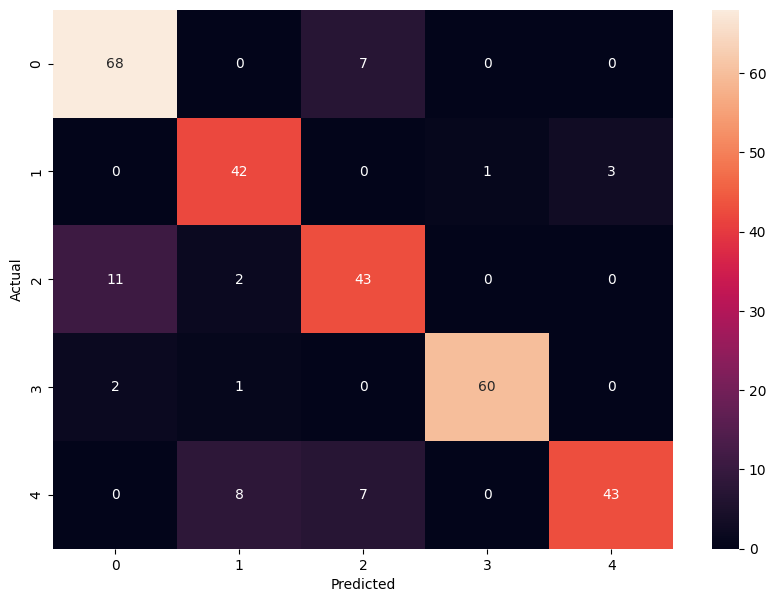

In [214]:
cm_GRU = confusion_matrix(Y_test_labels_encoded, model_GRU_predict_probabilities.argmax(axis=1))
plt.figure(figsize=(10,7))
sns.heatmap(cm_GRU, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [217]:
all_model_results = pd.DataFrame({"LSTM": model_LSTM_results,"Bidirectional": model_Bi_LSTM_results,"GRU": model_GRU_results})

In [218]:
all_model_results = all_model_results.transpose()
all_model_results

,Accuracy,Precision,Recall,F1 Score
LSTM,91.946309,91.946309,0.919463,0.919285
Bidirectional,82.214765,82.214765,0.822148,0.816372
GRU,85.906040,85.906040,0.859060,0.858938


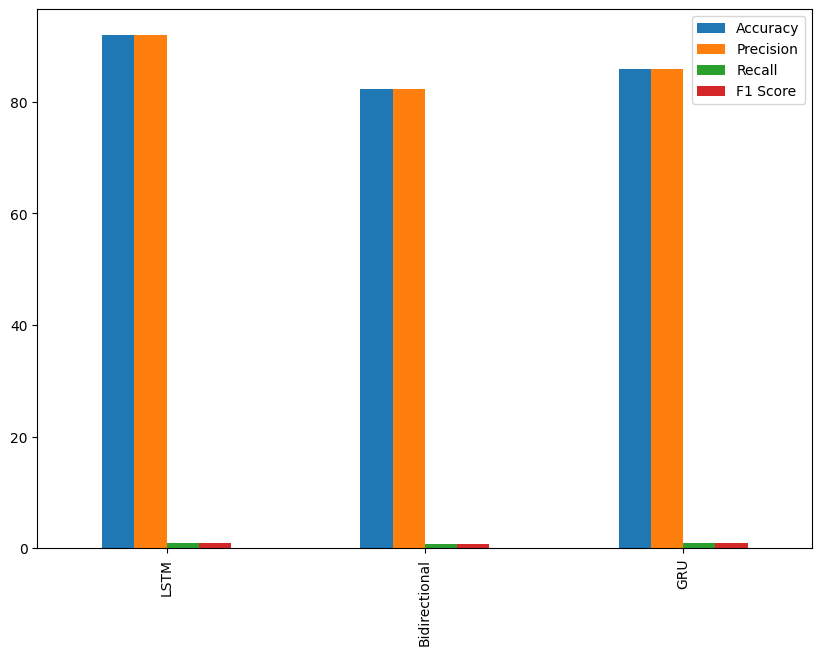

In [219]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

## Save and load DL models

In [220]:
model_LSTM.save('models/model_LSTM.h5')
model_LSTM.save_weights('models/model_LSTM_weights.h5')

In [221]:
model_GRU.save('models/model_GRU.h5')
model_GRU.save_weights('models/model_GRU_weights.h5')

In [222]:
model_Bi_LSTM.save('models/model_Bi_LSTM.h5')
model_Bi_LSTM.save_weights('models/model_Bi_LSTM_weights.h5')

In [223]:
# load model
model_LSTM_load =tensorflow.keras.models.load_model('models/model_LSTM.h5')
# Summary
model_LSTM_load.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 spatial_dropout1d_8 (Spatia  (None, 500, 128)         0         
 lDropout1D)                                                     
                                                                 
 lstm_8 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 5)                 645       
                                                                 
Total params: 1,412,229
Trainable params: 1,412,229
Non-trainable params: 0
____________________________________________

In [224]:
# load model
model_Bi_LSTM_load =tensorflow.keras.models.load_model('models/model_Bi_LSTM.h5')
# Summary
model_Bi_LSTM_load.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 spatial_dropout1d_9 (Spatia  (None, 500, 128)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)             

In [225]:
# load model
model_GRU_load =tensorflow.keras.models.load_model('models/model_GRU.h5')
# Summary
model_GRU_load.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 500, 128)          1280000   
                                                                 
 spatial_dropout1d_10 (Spati  (None, 500, 128)         0         
 alDropout1D)                                                    
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 5)                 645       
                                                                 
Total params: 1,379,717
Trainable params: 1,379,717
Non-trainable params: 0
___________________________________________

In [226]:
detect_catagory_dl(model_Bi_LSTM_load,article1)

1/1 [==============================] - 2s 2s/step


(array([[0.12945817, 0.02301823, 0.54306334, 0.00857033, 0.29589   ]],
       dtype=float32),
 'politics')

In [227]:
detect_catagory_dl(model_GRU_load,article3)

1/1 [==============================] - 0s 405ms/step


(array([[2.1433027e-04, 1.2224948e-01, 1.0099259e-02, 2.2635995e-04,
         8.6721063e-01]], dtype=float32),
 'tech')

In [229]:
detect_catagory_dl(model_LSTM_load,article3)

1/1 [==============================] - 0s 277ms/step


(array([[0.06815598, 0.2989159 , 0.08044846, 0.12254515, 0.42993456]],
       dtype=float32),
 'tech')